In [72]:
import numpy as np
import pandas as pd
import random
import math
import statistics 
from math import sqrt
import matplotlib.pyplot as plt

In [102]:
def generate_data(p, n):
    
    coeffs = np.random.normal(loc=0, scale=1, size=(p,1))
    coeff = np.array(coeffs).reshape(p, 1)
    z = int(len(coeff) * 0.9)
    i = np.random.choice(10)
    coeff[i:z+i] = 0
    A = []
    for i, item in enumerate(coeff):
        if item != 0:
            A.append(i)
        
    x = np.random.normal(loc=0, scale=1/np.sqrt(p), size=(n,p)) 
    std = 0.3
    e = np.random.normal(0, size=(n,1)) * std
    SNR = np.std(x.dot(coeff))/np.std(e)
    y = x.dot(coeff) + e
    
    return coeff, A, std, e, x, y, SNR

coeff, A, std, e, x, y, SNR = generate_data(50, 5000)

In [103]:
A

[0, 1, 2, 48, 49]

In [104]:
print("Predictors matrix: ", x.shape)
print("Coeffs matrix: ", coeff.shape)
print("Error matrix: ", e.shape)
print("Response matrix: ", y.shape)

Predictors matrix:  (5000, 50)
Coeffs matrix:  (50, 1)
Error matrix:  (5000, 1)
Response matrix:  (5000, 1)


In [105]:
#print("The stdev of the error: ", std)
print("SNR: ", SNR)

SNR:  1.3652062853838696


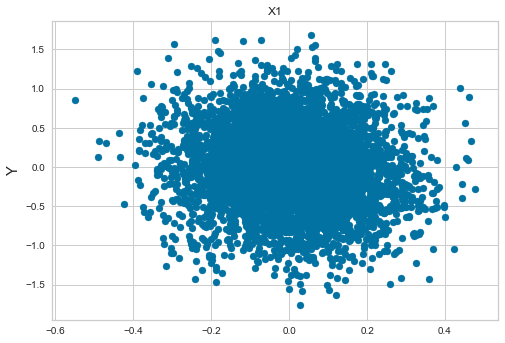

In [106]:
#plot some predictors with y
plt.scatter(x[:,0], y)
plt.title("X1")
plt.ylabel('Y', fontsize=15)

plt.show();

### Lasso

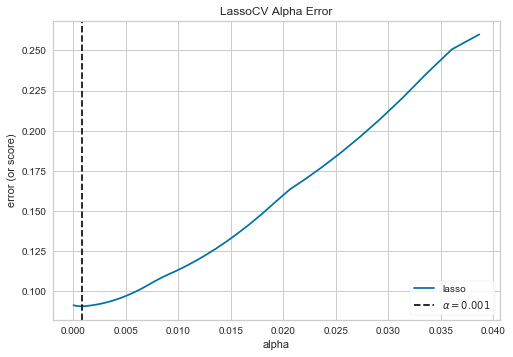

Lasso best lamda (alpha):  0.0008327332718405411


In [107]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from yellowbrick.regressor import AlphaSelection

y = np.ravel(y)
ml = LassoCV(cv=10)
visualizer = AlphaSelection(ml)
visualizer.fit(x, y)
visualizer.show();

print("Lasso best lamda (alpha): ",visualizer.estimator.alpha_)

In [108]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=visualizer.estimator.alpha_)
clf.fit(x, y)
beta_lasso = clf.coef_
A_lasso = []
for i, item in enumerate(beta_lasso):
    if item != 0:
        A_lasso.append(i)

In [109]:
#print true and alpha betas
true_beta = np.ravel(coeff)
print(" True Beta indices: \n", A )
print()
print(" Lasso Beta indices: \n", A_lasso )

 True Beta indices: 
 [0, 1, 2, 48, 49]

 Lasso Beta indices: 
 [0, 1, 2, 3, 9, 11, 12, 19, 25, 26, 43, 48, 49]


In [110]:
#print true and alpha betas
true_beta = np.ravel(coeff)
print(" True Beta: \n", true_beta )
print()
print(" Lasso Beta: \n", beta_lasso)

 True Beta: 
 [-0.39316355  0.46455035  1.99966636  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -1.06219464  1.82431891]

 Lasso Beta: 
 [-3.51977343e-01  4.18127302e-01  1.99165383e+00 -3.66746470e-02
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.81135326e-03  0.00000000e+00  3.11693681e-02
 -7.20416007e-04  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.07874315e-02
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.18449974e-02 -

In [111]:
#confusion matrix true vs lasso
def true_lasso(a, b):
    l1 = 0
    l2 = 0
    l3 = 0
    l4 = 0

    for i in range(50):
        if true_beta[i] != 0 and beta_lasso[i] != 0:
            l1 += 1
        elif true_beta[i] == 0 and beta_lasso[i] != 0:
            l2 += 1
        elif true_beta[i] != 0 and beta_lasso[i] == 0:
            l3 += 1
        elif true_beta[i] == 0 and beta_lasso[i] == 0:
            l4 += 1
    return l1, l2, l3, l4

l1, l2, l3, l4 = true_lasso(true_beta, beta_lasso)

In [124]:
print('                      Confusion Matrix - Lasso')
print()
print(' True/Recoverd       | non_zero true coeff    |  zero true coeff ')
print('----------------------------------------------------------------')
print('non_zero recov coeff | {}                     | {}'.format(int(l1), int(l2)))
print('zero recov coeff     | {}                     | {}'.format(int(l3), int(l4)))

#sensitivity and specificity true vs lasso
 
Sensitivity_l = int(l1) / ((int(l1) + int(l3)))
Specificity_l = int(l4) / ((int(l4) + int(l2)))
print()
print()
print("Sensitivity_lasso: ", Sensitivity_l)
print("Specificity_lasso: ", Specificity_l)

                      Confusion Matrix - Lasso

 True/Recoverd       | non_zero true coeff    |  zero true coeff 
----------------------------------------------------------------
non_zero recov coeff | 5                     | 8
zero recov coeff     | 0                     | 37


Sensitivity_lasso:  1.0
Specificity_lasso:  0.8222222222222222


### Adaptive Lasso

In [114]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from numpy.linalg import inv
#get weights from the ridge regression

mr = RidgeCV(alphas=[0.1, 10, 1]).fit(x, y)
w = mr.coef_
w = np.diag(w)
xt = x.dot(w.transpose())

clf_ad = linear_model.Lasso(alpha=visualizer.estimator.alpha_)
clf_ad.fit(xt, y)
beta_llasso = clf_ad.coef_

beta_adlasso = w.transpose().dot(beta_llasso)

A_adlasso = []
for i, item in enumerate(beta_adlasso):
    if item != 0:
        A_adlasso.append(i)
print(A_adlasso)

[0, 1, 2, 48, 49]


In [115]:
#print true and alpha betas
true_beta = np.ravel(coeff)
print(" True Beta: \n", true_beta )
print()
print(" Adaptive Lasso Beta: \n", beta_adlasso)

 True Beta: 
 [-0.39316355  0.46455035  1.99966636  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -1.06219464  1.82431891]

 Adaptive Lasso Beta: 
 [-0.28959594  0.368421    2.01180905  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

In [116]:
#confusion matrix true vs adaptive lasso
def true_adlasso(a, b):
    ad1 = 0
    ad2 = 0
    ad3 = 0
    ad4 = 0

    for i in range(50):
        if true_beta[i] != 0 and beta_adlasso[i] != 0:
            ad1 += 1
        elif true_beta[i] == 0 and beta_adlasso[i] != 0:
            ad2 += 1
        elif true_beta[i] != 0 and beta_adlasso[i] == 0:
            ad3 += 1
        elif true_beta[i] == 0 and beta_adlasso[i] == 0:
            ad4 += 1
    return ad1, ad2, ad3, ad4

ad1, ad2, ad3, ad4 = true_adlasso(true_beta, beta_adlasso)

In [123]:
print('                      Confusion Matrix - Adaptive Lasso')
print()
print(' True/Recoverd       | non_zero true coeff    |  zero true coeff ')
print('----------------------------------------------------------------')
print('non_zero recov coeff | {}                     | {}'.format(int(ad1), int(ad2)))
print('zero recov coeff     | {}                     | {}'.format(int(ad3), int(ad4)))

Specificity_ad = int(ad4) / ((int(ad4) + int(ad2)))
print()
print()
print("Sensitivity_adlasso: ", Sensitivity_ad)
print("Specificity_adlasso: ", Specificity_ad)

                      Confusion Matrix - Adaptive Lasso

 True/Recoverd       | non_zero true coeff    |  zero true coeff 
----------------------------------------------------------------
non_zero recov coeff | 5                     | 0
zero recov coeff     | 0                     | 45


Sensitivity_adlasso:  1.0
Specificity_adlasso:  1.0
